# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously
Original: https://colab.research.google.com/gist/bucekj/8c913671f00d4ee2ac59649cbd6b9b7b#scrollTo=8fW8nPQ5uyEO 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

# read plaintext inputs
inputs = load_text("plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())

# trim each trace - select interesting part
start = 0
len = trace_length # CHANGE to the length of the first round; 

# read traces from binary file
traces = np.fromfile("traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, start:len] # select only the interesting part of each trace

print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

%matplotlib widget

(499, 16)
1171875
(500, 1171875)


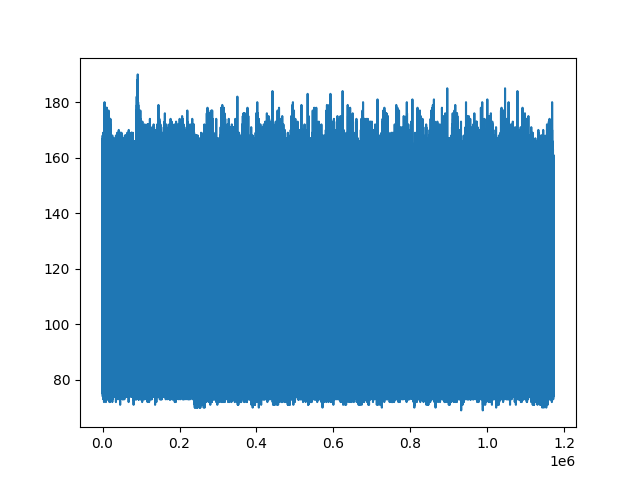

In [2]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()

## **Attack the first key byte**


In [3]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [4]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat) 

[[209 195 197 ... 122  31 200]
 [251 247 124 ... 197 117  17]
 [ 34  34  90 ...  75 192 140]
 ...
 [231 185 222 ...  25 127 228]
 [122 110 211 ... 133 133 202]
 [ 78  21 154 ...  26 239  88]]
(499, 16)
(499,)
(499, 1)
(256,)
(499, 256)
[[209 208 211 ...  44  47  46]
 [251 250 249 ...   6   5   4]
 [ 34  35  32 ... 223 220 221]
 ...
 [231 230 229 ...  26  25  24]
 [122 123 120 ... 135 132 133]
 [ 78  79  76 ... 179 176 177]]


In [5]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [6]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
hmat = hw_table[smat]

In [7]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
print(hmat.shape)
print(traces[0:499,:].shape)
corr = correlate(hmat, traces[0:499,0:50000])
# What is the shape and contents of the correlation matrix?

(499, 256)
(499, 1171875)


In [8]:
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))

key: 68 time: 8151
key: D, 44


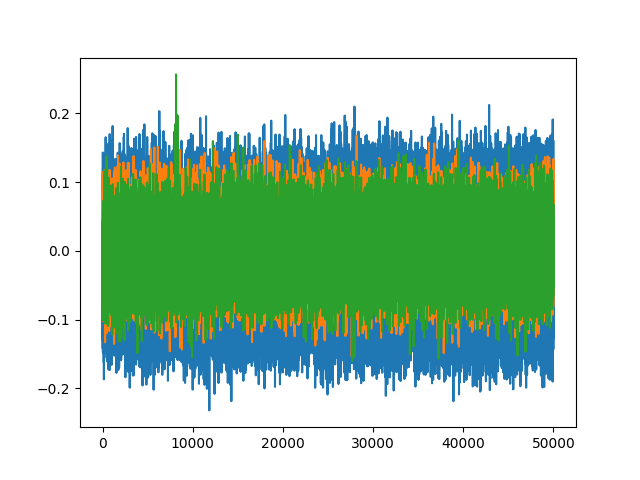

In [9]:
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()

plt.plot(corr[k[0]+1])
plt.plot(corr[k[0]-1])
plt.plot(corr[k[0]])
plt.show()

## **Break all key bytes!**

In [10]:
from Crypto.Cipher import AES
%matplotlib widget

ciphertext = load_text("ciphertext.txt")
plaintextBlock = bytes(inputs[0])
ciphertextBlock = bytes(ciphertext[0])

def test_key(kk):
    key_bytes = bytes(kk)
    cipher = AES.new(key_bytes, AES.MODE_ECB)

    # Encrypting the plaintext using the cipher object
    encrypted_plaintext = cipher.encrypt(plaintextBlock)

    # Verifing that the encrypted plaintext matches the given ciphertext
    if encrypted_plaintext == ciphertextBlock:
        print("The key is valid !")
    else:
        print("Invalid key :(")

def display_correlation(corr, k):
    if k > 0  and k < 255:
        fig = plt.figure()
        plt.plot(corr[k+1])
        plt.plot(corr[k-1])
        plt.plot(corr[k])
        plt.show()
    else:
        print("k out of range for ploting")

- Discover the secret key (with hamming wieght power model)

In [11]:
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    inp = inputs[:, i]
    # XOR each data byte with each key
    xmat = inp[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consumption
    hmat = hw_table[smat]
    # Find correlation between hamming weights and traces
    corr = correlate(hmat, traces[0:499,300000:350000])
    # Display first key byte correlation trace
    acorr = abs(corr)
    # Find the most correlated key and store it in the corr_table
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find indices of maximum
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
test_key(kk)
correct_key = kk

Ê, ca @ 17124
þ, fe @ 9452
º, ba @ 1355
¾, be @ 4142
 , 20 @ 7813
, 15 @ 8749
, 03 @ 2109
, 19 @ 4896
=, 3d @ 7858
, 1a @ 9223
%, 25 @ 141
M, 4d @ 5650
n, 6e @ 8632
e, 65 @ 9333
d, 64 @ 895
i, 69 @ 11700
The key is valid !


- Use 3 different power models:
    - Hamming weight
    - Hamming distance – choose a suitable pair of intermediate variables, e.g. d ⊕ k and S(d ⊕ k)
    - Single bit

In [12]:
def LSB_key_search(n_trace, correct_key = None):
    keys = np.array(range(0, 256))
    kk = np.zeros(16, dtype='uint8')
    PGE_table = []
    for i in range(0, 16):
        inp = inputs[:, i]
        # XOR each data byte with each key
        xmat = inp[:, np.newaxis] ^ keys
        # Substitute with SBOX all XORed n_traces -- matrix of intermediate values
        smat = sbox[xmat]
        # LSB
        lsb_mat = np.where(smat%2 == 0, 0, 1)
        # Find correlation between LSB and traces
        corr = correlate(lsb_mat[0:n_trace], traces[0:n_trace,300000:350000])
        acorr = abs(corr)
        # Find the most correlated key
        max_acorr = acorr.max()
        (k, j) = np.where(acorr == max_acorr) # find indices of maximum
        kk[i] = k
        if correct_key is not None:
            all_max_accor = np.amax(acorr, axis=1)
            sorted_acorr = np.flip(np.argsort(all_max_accor))
            pge = np.where(sorted_acorr == correct_key[i])[0][0]
            PGE_table.append(pge)
    return kk, PGE_table

def HD_key_search(n_trace, correct_key = None):
    keys = np.array(range(0, 256))
    kk = np.zeros(16, dtype='uint8')
    previous_key = np.copy(hw_table)
    PGE_table = []
    for i in range(0, 16):
        inp = inputs[:, i]
        # XOR each data byte with each key
        xmat = inp[:, np.newaxis] ^ keys
        # Substitute with SBOX all XORed values -- matrix of intermediate values
        smat = sbox[xmat]
        # Compute Hamming distance
        dmat = previous_key ^ smat
        hmat = hw_table[dmat]
        # Find correlation between hamming weights and traces
        corr = correlate(hmat[0:n_trace], traces[0:n_trace,300000:350000])
        acorr = abs(corr)
        # Find the most correlated key
        max_acorr = acorr.max()
        (k, j) = np.where(acorr == max_acorr) # find indices of maximum
        kk[i] = k
        # Compute the PGE if the correct key correlation is provided
        if correct_key is not None:
            all_max_accor = np.amax(acorr, axis=1)
            sorted_acorr = np.flip(np.argsort(all_max_accor))
            pge = np.where(sorted_acorr == correct_key[i])[0][0]
            PGE_table.append(pge)
    return kk, PGE_table

def HW_key_search(n_trace, correct_key = None):
    keys = np.array(range(0, 256))
    kk = np.zeros(16, dtype='uint8')
    PGE_table = []
    for i in range(0, 16):
        inp = inputs[:, i]
        # XOR each data byte with each key
        xmat = inp[:, np.newaxis] ^ keys
        # Substitute with SBOX all XORed values -- matrix of intermediate values
        smat = sbox[xmat]
        # Compute Hamming Weights -- the matrix of hypothetical power consumption
        hmat = hw_table[smat]
        # Find correlation between hamming weights and traces
        corr = correlate(hmat[0:n_trace], traces[0:n_trace,300000:350000])
        acorr = abs(corr)
        # Find the most correlated key
        max_acorr = acorr.max()
        (k, j) = np.where(acorr == max_acorr) # find indices of maximum
        kk[i] = k
        # Compute the PGE if the correct key correlation is provided
        if correct_key is not None:
            all_max_accor = np.amax(acorr, axis=1)
            sorted_acorr = np.flip(np.argsort(all_max_accor))
            pge = np.where(sorted_acorr == correct_key[i])[0][0]
            PGE_table.append(pge)
    return kk, PGE_table


print("Find key with hamming weight power model...")
key, pge_table = HW_key_search(499)
test_key(key)
print("Find key with hamming distance power model...")
key, pge_table = HD_key_search(499)
test_key(key)
print("Find key with single bit power model...")
key, pge_table = LSB_key_search(499)
test_key(key)

Find key with hamming weight power model...
The key is valid !
Find key with hamming distance power model...
Invalid key :(
Find key with single bit power model...
The key is valid !


- For the first key byte (and each power model):
    - Display a plot of the correlation traces for the right guess and 2 (neighboring) wrong guesses (in a single plot)
    - Explain the number and position of correlation peaks of the right key (based on the overall knowledge of the AES algorithm)

Hamming weight - correlation traces for the right guess and 2 wrong guesses


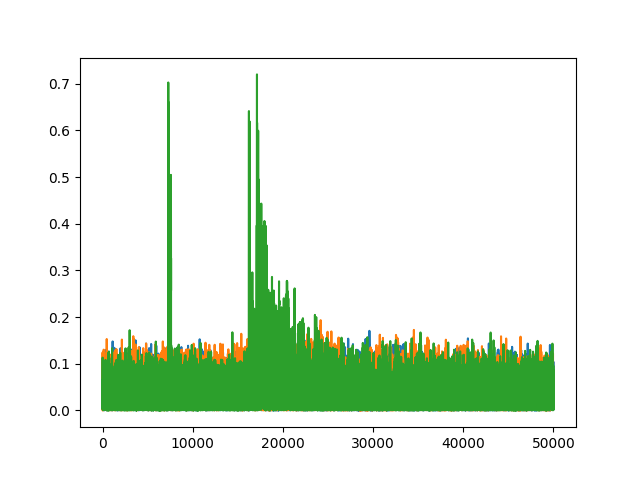

Hamming distance - correlation traces for the right guess and 2 wrong guesses


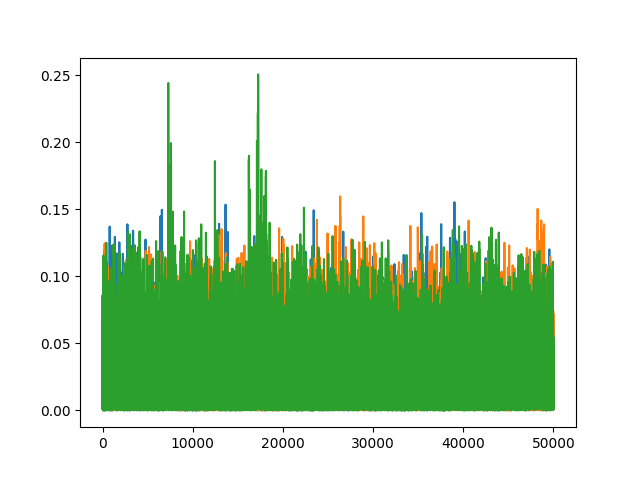

LSB - correlation traces for the right guess and 2 wrong guesses


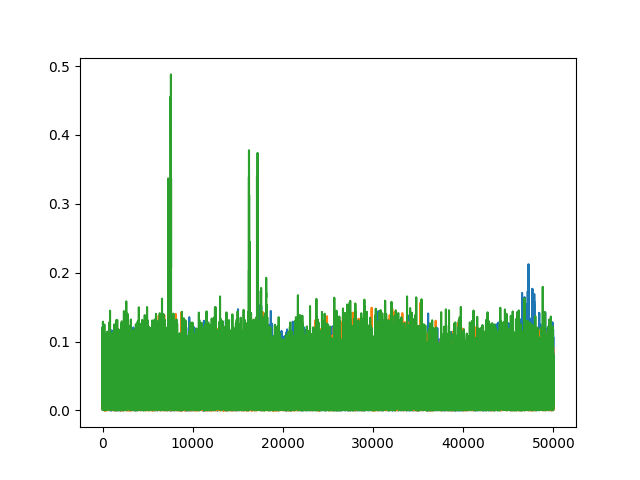

In [27]:

keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')

inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

# Compute Hamming Weights and find the most correlated key
hw_hmat = hw_table[smat]
hw_corr = correlate(hw_hmat[0:499], traces[0:499,300000:350000])
hw_acorr = abs(hw_corr)
hw_max_acorr = hw_acorr.max()
(hw_k, j) = np.where(hw_corr == hw_max_acorr) # find indices of maximum
print("Hamming weight - correlation traces for the right guess and 2 wrong guesses")
display_correlation(hw_acorr, hw_k.item())

# Compute Hamming distance and find the most correlated key
# TODO wrong (maybe miss a XOR somewhere)
previous_key = np.copy(hw_table)
hd_dmat = xmat ^ smat
hd_hmat = hw_table[hd_dmat]
hd_corr = correlate(hd_hmat[0:499], traces[0:499,300000:350000])
hd_acorr = abs(hd_corr)
hd_max_acorr = hd_acorr.max()
(hd_k, j) = np.where(hd_acorr == hd_max_acorr) # find indices of maximum
print("Hamming distance - correlation traces for the right guess and 2 wrong guesses")
display_correlation(hd_acorr, hd_k.item())

# Compute Hamming Weights and find the most correlated key
lsb_mat = np.where(smat%2 == 0, 0, 1)
lsb_corr = correlate(lsb_mat[0:499], traces[0:499,300000:350000])
lsb_acorr = abs(lsb_corr)
lsb_max_acorr = lsb_acorr.max()
(lsb_k, j) = np.where(lsb_corr == lsb_max_acorr) # find indices of maximum
print("LSB - correlation traces for the right guess and 2 wrong guesses")
display_correlation(lsb_acorr, lsb_k.item())

> We can see from the plots that the correct key has much larger correlation than the neighbouring key guesses. This can be explained by the fact that the S-BOX operation is not linear and therefore can vary a lot even when only one bit of the key hypothesis differs. The fact that we see more than one peak probably means that the intermediate value we are attacking is used more than once. According to the DPA book by Mangard, Oswald and Popp linked on the task page, this is normal. The first peak should be when the SBX output is being calculated. It is the probably stored in some register until it's used again, in the shift rows operation.

- Repeat the analysis for n=50, 100, and 200 traces, knowing the correct key:
    - For each key byte and power model, find the order of the correct key from the best candidate to the worst (partial guessing entropy, PGE)
    - Present a big table of found keys and PGEs for all n, power model and key byte, so that we can compare the attack success in each case

In [14]:
# analysis for 50, 100 and 200 traces
LSB_PGE = []
HD_PGE = []
HW_PGE = []
print("We search the key for...")
for n_trace in [50, 100, 200]:
    lsb_key, lsb_pge = LSB_key_search(n_trace, correct_key)
    print(f"- {n_trace} traces with LSB power model:")
    test_key(lsb_key)
    LSB_PGE.append(lsb_pge)
    hd_key, hd_pge = HD_key_search(n_trace, correct_key)
    print(f"- {n_trace} traces with Hamming distance power model:")
    test_key(hd_key)
    HD_PGE.append(hd_pge)
    hw_key, hw_pge = HW_key_search(n_trace, correct_key)
    print(f"- {n_trace} traces with Hamming weight power model:")
    test_key(hw_key)
    HW_PGE.append(hw_pge)


We search the key for...
- 50 traces with LSB power model:
Invalid key :(
- 50 traces with Hamming distance power model:
Invalid key :(
- 50 traces with Hamming weight power model:
Invalid key :(
- 100 traces with LSB power model:
Invalid key :(
- 100 traces with Hamming distance power model:
Invalid key :(
- 100 traces with Hamming weight power model:
The key is valid !
- 200 traces with LSB power model:
The key is valid !
- 200 traces with Hamming distance power model:
Invalid key :(
- 200 traces with Hamming weight power model:
The key is valid !


Single byte PGE per byte


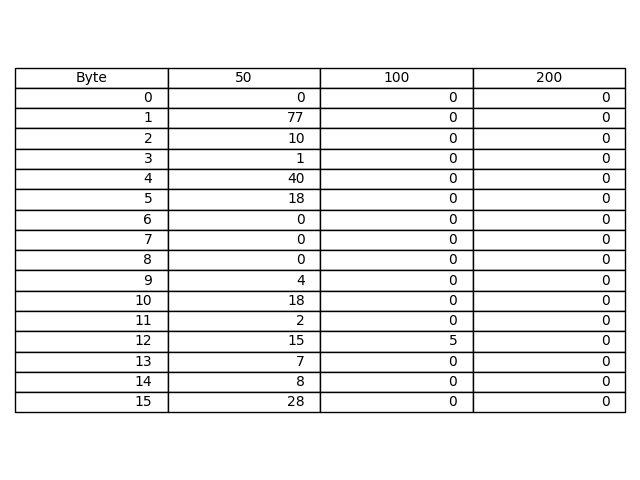

Hamming distance PGE per byte


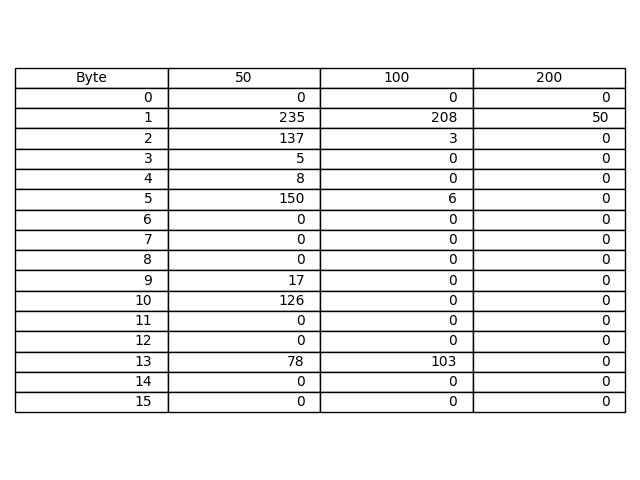

Hamming weight PGE per byte


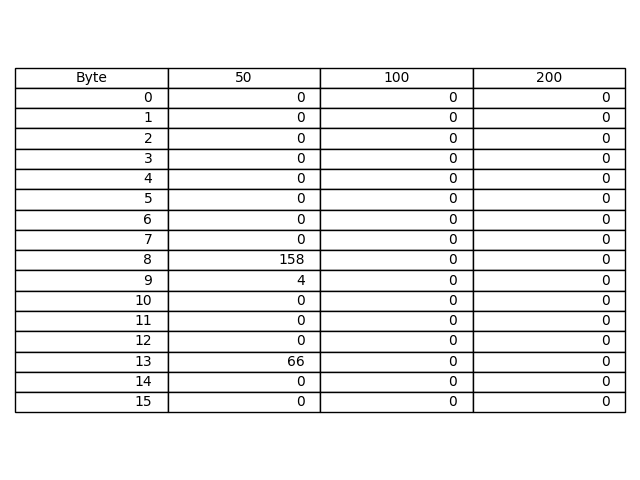

We compute the mean PGE for each power model to sort the candidates


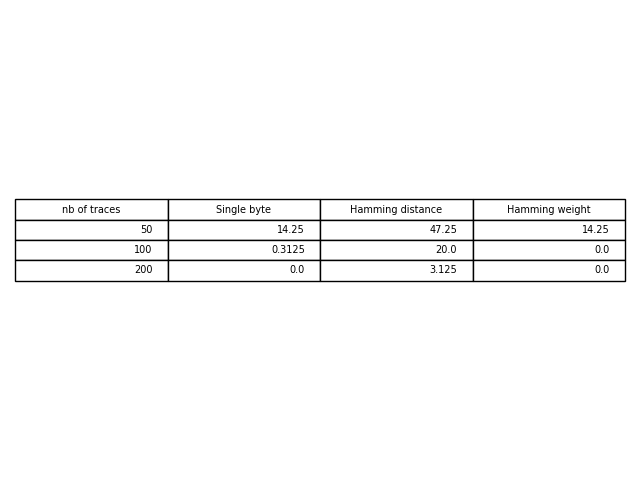

In [15]:
print("Single byte PGE per byte")
cells = np.array([[i for i in range(16)], LSB_PGE[0],LSB_PGE[1],LSB_PGE[2]])
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=cells.T, colLabels=["Byte","50", "100", "200"], loc='center')
fig.tight_layout()
plt.show()

print("Hamming distance PGE per byte")
cells = np.array([[i for i in range(16)], HD_PGE[0],HD_PGE[1],HD_PGE[2]])
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=cells.T, colLabels=["Byte","50", "100", "200"], loc='center')
fig.tight_layout()
plt.show()

print("Hamming weight PGE per byte")
cells = np.array([[i for i in range(16)], HW_PGE[0],HW_PGE[1],HW_PGE[2]])
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=cells.T, colLabels=["Byte","50", "100", "200"], loc='center')
fig.tight_layout()
plt.show()

print("We compute the mean PGE for each power model to sort the candidates")
LSB_mean = [np.mean(x) for x in LSB_PGE]
HD_mean = [np.mean(x) for x in HD_PGE]
HW_mean = [np.mean(x) for x in HW_PGE]


cells = np.array([["50","100","200"],LSB_mean, HD_mean, HW_mean])
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=cells.T, colLabels=["nb of traces", "Single byte", "Hamming distance", "Hamming weight"], loc='center')
fig.tight_layout()
plt.show()

## Attack the last round instead of the first

- Last round estimated to be between column 1120000 and 1180000.

In [16]:

# TODO input = ciphertext
# voir schema prof et mettre les bonnes operations
keys = np.array(range(0, 256))
last_round_key = np.zeros(16, dtype='uint8')
correlations = []
for i in range(0, 16):
    inp = inputs[:, i]
    # XOR each data byte with each key
    xmat = inp[:, np.newaxis] ^ keys
    # Substitute with SBOX all XORed values -- matrix of intermediate values
    smat = sbox[xmat]
    # Compute Hamming Weights -- the matrix of hypothetical power consumption
    hmat = hw_table[smat]
    # Find correlation between hamming weights and traces
    corr = correlate(hmat, traces[0:499,1120000:1180000])
    # Display first key byte correlation trace
    acorr = abs(corr)
    # Find the most correlated key
    max_acorr = acorr.max()
    correlations.append(max_acorr)
    (k, j) = np.where(acorr == max_acorr) # find indices of maximum
    kk[i] = k
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
    print(max_acorr)

[, 5b @ 47551
0.2267020708577132
x, 78 @ 24701
0.22323630446746137
y, 79 @ 34817
0.21759837577738805
s, 73 @ 23506
0.23351166756110942
, 04 @ 4196
0.21307084761769887
þ, fe @ 18129
0.23913653604661964
^, 5e @ 30669
0.21380622005193436
,, 2c @ 49372
0.2145793232911935
, 93 @ 39455
0.21887559305070886
», bb @ 35506
0.21567930504647792
Q, 51 @ 14359
0.2139026166288999
F, 46 @ 42341
0.2200146908624799
Ã, c3 @ 12917
0.20883908595602543
r, 72 @ 28339
0.22229813824669264
, 04 @ 43668
0.22616642984083413
Ã, c3 @ 33718
0.23148345191276076


In the AES algorithm, the key is different in each round and this is because of the key schedule algorithm. before each round, the key is modified according to a series of operations. In order to attack the last round key we need to take the last key used to encrypt and then iterate through a reverse key expansion algorithm until we reach the first key.

In [17]:
rcon = np.array([0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36], dtype='uint8')
inv_sbox = np.flip(sbox, 0)

def reverse_key_expansion(last_round_key, inv_sbox):
    # Define the number of rounds and the number of words in the key
    num_rounds = 10
    num_words = 4*(num_rounds + 1)
    
    # Initialize the key schedule with the last round key
    key_schedule = np.zeros((num_words, 4), dtype=np.uint8)
    key_schedule[num_words-4:num_words,:] = last_round_key

    # Iterate backwards through the key schedule, computing each word in turn
    j=9
    for i in range(num_words-5, -1, -1):
        if i % 4 == 0:
            # Apply the key schedule core to the previous word in the schedule
            temp = key_schedule[i+1,:].copy()
            # Rcon lookup
            temp[0] ^= rcon[j]
            temp = np.array([inv_sbox[b] for b in temp])
            temp = np.roll(temp, -1)
            key_schedule[i,:] = np.bitwise_xor(key_schedule[i+4,:], temp)
            j -= 1
        else:
            key_schedule[i,:] = np.bitwise_xor(key_schedule[i+4,:], key_schedule[i+1,:])
    return key_schedule

print("Last roud key to attack:\n" + str(last_round_key))
cracked_key = reverse_key_expansion(last_round_key.reshape(4,4), inv_sbox)
cracked_key = cracked_key[0:4, :].reshape(16,)
print("Finaly key:\n" + str(cracked_key))
test_key(cracked_key)

Last roud key to attack:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Finaly key:
[226  90 125 212   2 229 194 178  51 191 129   9 189 206  33 191]
Invalid key :(


For some reason this algorithm doesn't work anymore, but has already worked